# Deep Learning Midterm - Online Transaction

## *Sahrul Ridho Firdaus - 1103223009*

In this assignment, you will develop end-to-end machine learning and deep learning models using the provided dataset. 
This includes data preprocessing, model selection, training, evaluation, and comparison of performance across traditional machine learning models and deep learning architectures. 
Your task is to build a comprehensive pipeline and analyze the results to draw meaningful conclusions.

# Import Library

Import all necessary libraries for data processing, deep learning (PyTorch), machine learning (LightGBM), class balancing (SMOTE), and visualization.

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
import lightgbm as lgb
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
import warnings
warnings.filterwarnings('ignore')

## Check for CUDA Availability

Verify PyTorch installation and check if CUDA is available for GPU acceleration. This displays PyTorch version, CUDA availability, and GPU device information.

In [2]:
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
    print(f"Device count: {torch.cuda.device_count()}")

PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA version: 12.4
Device name: NVIDIA GeForce RTX 3050 Laptop GPU
Device count: 1
CUDA available: True
CUDA version: 12.4
Device name: NVIDIA GeForce RTX 3050 Laptop GPU
Device count: 1


## Data Pre-Processing

### Class Distribution Analysis

Load the training and test transaction datasets from CSV files for fraud detection analysis.

In [3]:
BASE_PATH = "./Fraud Transaction"

train = pd.read_csv(f"{BASE_PATH}/train_transaction.csv")
test = pd.read_csv(f"{BASE_PATH}/test_transaction.csv")

Analyze class distribution to understand the imbalance between fraud and non-fraud transactions. Calculate class weights for handling imbalanced data and display fraud rate statistics.

In [4]:
train= pd.read_csv(f"{BASE_PATH}/train_transaction.csv")
test= pd.read_csv(f"{BASE_PATH}/test_transaction.csv")

print("CLASS DISTRIBUTION")

print(f"\nOriginal Training Data:")
print(train['isFraud'].value_counts())
print(f"\nClass Ratio:")
fraud_ratio = train['isFraud'].value_counts(normalize=True)
print(fraud_ratio)
print(f"\nFraud Rate: {fraud_ratio[1]:.4%}")

class_weights = compute_class_weight('balanced', 
                                      classes=np.unique(train['isFraud']), 
                                      y=train['isFraud'])
print(f"\nClass Weights: {dict(zip([0, 1], class_weights))}")
print("="*60)

CLASS DISTRIBUTION

Original Training Data:
isFraud
0    569877
1     20663
Name: count, dtype: int64

Class Ratio:
isFraud
0    0.96501
1    0.03499
Name: proportion, dtype: float64

Fraud Rate: 3.4990%

Class Weights: {0: np.float64(0.5181293507195412), 1: np.float64(14.289793350433142)}


### Advanced Feature Engineering

Create advanced features from raw transaction data including log transforms, time-based features, card-transaction interactions, aggregations, and missing value indicators to improve model performance.

In [5]:
def engineer_features(df, is_train=True):

    df = df.copy()
    
    # 1. Log1p transforms for amount-related features
    amount_cols = [col for col in df.columns if 'amount' in col.lower() or 'TransactionAmt' in col]
    for col in amount_cols:
        if col in df.columns and df[col].dtype in ['float64', 'int64']:
            df[f'{col}_log1p'] = np.log1p(df[col].fillna(0))
    
    # 2. Time-based features (if TimeDelta exists)
    if 'TransactionDT' in df.columns:
        df['TransactionDT_hour'] = (df['TransactionDT'] / 3600) % 24
        df['TransactionDT_day'] = (df['TransactionDT'] / 86400) % 7
        df['TransactionDT_week'] = (df['TransactionDT'] / 604800)
        
    # 3. Interaction features
    if 'TransactionAmt' in df.columns:
        # Card transaction patterns
        if 'card1' in df.columns:
            df['amt_card1_ratio'] = df['TransactionAmt'] / (df.groupby('card1')['TransactionAmt'].transform('mean') + 1)
        if 'card2' in df.columns:
            df['amt_card2_ratio'] = df['TransactionAmt'] / (df.groupby('card2')['TransactionAmt'].transform('mean') + 1)
        
        # Amount bins
        df['amt_bin'] = pd.cut(df['TransactionAmt'], bins=10, labels=False)
    
    # 4. Card aggregation features
    card_cols = [col for col in df.columns if 'card' in col.lower()]
    for col in card_cols[:4]:  # Limit to first 4 card columns
        if col in df.columns and df[col].dtype in ['float64', 'int64']:
            df[f'{col}_count'] = df.groupby(col)[col].transform('count')
    
    # 5. Missing value indicators
    df['missing_count'] = df.isnull().sum(axis=1)
    
    # 6. Email domain features (if exists)
    email_cols = [col for col in df.columns if 'email' in col.lower()]
    for col in email_cols:
        if col in df.columns:
            df[f'{col}_nan'] = df[col].isnull().astype(int)
    
    # 7. Device info features
    if 'DeviceInfo' in df.columns:
        df['DeviceInfo_nan'] = df['DeviceInfo'].isnull().astype(int)
    
    return df

print("Engineering features for train and test sets...")
train_fe = engineer_features(train, is_train=True)
test_fe = engineer_features(test, is_train=False)
print(f"Original features: {train.shape[1]}")
print(f"After feature engineering: {train_fe.shape[1]}")
print(f"New features added: {train_fe.shape[1] - train.shape[1]}")

Engineering features for train and test sets...
Original features: 394
After feature engineering: 407
New features added: 13
Original features: 394
After feature engineering: 407
New features added: 13


### Data Preprocessing with SMOTE

Preprocess the data by encoding categorical variables, filling missing values, splitting into train/validation sets, applying SMOTE to balance classes, and scaling features for neural network training.

In [8]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Prepare data
y_full = train_fe['isFraud']
X_full = train_fe.drop(['isFraud'], axis=1)
X_test_final = test_fe.copy()

# Encode categorical features
cat_cols = X_full.select_dtypes(include=['object']).columns
print(f"\nEncoding {len(cat_cols)} categorical columns...")

for col in cat_cols:
    le = LabelEncoder()
    combined = pd.concat([X_full[col], X_test_final[col]], axis=0).astype(str)
    le.fit(combined)
    X_full[col] = le.transform(X_full[col].astype(str))
    X_test_final[col] = le.transform(X_test_final[col].astype(str))

# Fill missing values
print("Filling missing values...")
X_full = X_full.fillna(X_full.median(numeric_only=True))
X_test_final = X_test_final.fillna(X_test_final.median(numeric_only=True))

# Train-validation split with stratification
X_train_full, X_valid_full, y_train_full, y_valid_full = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

print(f"\nOriginal train size: {X_train_full.shape}")
print(f"Validation size: {X_valid_full.shape}")

# Apply SMOTE to training data only
print("\nApplying SMOTE to balance training data...")
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_full, y_train_full)

print(f"After SMOTE: {X_train_balanced.shape}")
print(f"Class distribution after SMOTE:")
print(pd.Series(y_train_balanced).value_counts())

# Scale features
print("\nScaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_valid_scaled = scaler.transform(X_valid_full)
X_test_scaled = scaler.transform(X_test_final)

print("Preprocessing completed!")


Encoding 14 categorical columns...
Filling missing values...
Filling missing values...

Original train size: (472432, 406)
Validation size: (118108, 406)

Applying SMOTE to balance training data...

Original train size: (472432, 406)
Validation size: (118108, 406)

Applying SMOTE to balance training data...
After SMOTE: (911804, 406)
Class distribution after SMOTE:
isFraud
0    455902
1    455902
Name: count, dtype: int64

Scaling features...
After SMOTE: (911804, 406)
Class distribution after SMOTE:
isFraud
0    455902
1    455902
Name: count, dtype: int64

Scaling features...
Preprocessing completed!
Preprocessing completed!


## Train the Deep Learning Model

### PyTorch MLP with BatchNorm

Define an improved Multi-Layer Perceptron (MLP) architecture with BatchNormalization layers, Dropout for regularization, and 3 hidden layers (256→128→64) for robust fraud detection.

In [12]:
from torch import nn


class ImprovedFraudMLP(nn.Module):
    def __init__(self, input_dim):
        super(ImprovedFraudMLP, self).__init__()
        
        # Layer 1
        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.3)
        
        # Layer 2
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.3)
        
        # Layer 3
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.dropout3 = nn.Dropout(0.2)
        
        # Output layer
        self.fc4 = nn.Linear(64, 1)
        
    def forward(self, x):
        # Layer 1
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        
        # Layer 2
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        
        # Layer 3
        x = self.fc3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout3(x)
        
        # Output
        x = self.fc4(x)
        x = torch.sigmoid(x)
        
        return x

print("MLP Architecture:")
print("="*60)
model_nn = ImprovedFraudMLP(input_dim=X_train_scaled.shape[1])
print(model_nn)
print("="*60)
print(f"Total parameters: {sum(p.numel() for p in model_nn.parameters())}")

MLP Architecture:
ImprovedFraudMLP(
  (fc1): Linear(in_features=406, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
)
Total parameters: 146305


### Training with StratifiedKFold, AdamW, and LR Scheduler

Train the PyTorch MLP model with advanced techniques: AdamW optimizer, CosineAnnealingLR scheduler for learning rate decay, early stopping based on validation AUC, and track performance across epochs.

In [14]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score

class ImprovedEarlyStopping:
    def __init__(self, patience=5, min_delta=0.0001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_state = None

    def __call__(self, score, model):
        if self.best_score is None or score > self.best_score + self.min_delta:
            self.best_score = score
            self.best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

def train_pytorch_model(X_train, y_train, X_valid, y_valid, n_epochs=50):
    """Train PyTorch MLP with all improvements"""
    
    # Convert to numpy if needed
    if hasattr(y_train, 'values'):
        y_train = y_train.values
    if hasattr(y_valid, 'values'):
        y_valid = y_valid.values
    
    # Convert to tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
    y_valid_tensor = torch.tensor(y_valid, dtype=torch.float32).view(-1, 1)
    
    # Create data loaders
    train_ds = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_ds, batch_size=2048, shuffle=True)
    
    # Initialize model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ImprovedFraudMLP(input_dim=X_train.shape[1]).to(device)
    
    # Loss and optimizer (AdamW with weight decay)
    criterion = nn.BCELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
    
    # Learning rate scheduler
    scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs, eta_min=1e-6)
    
    # Early stopping
    early_stopper = ImprovedEarlyStopping(patience=5, min_delta=0.0001)
    
    print(f"\nTraining on device: {device}")
    print("="*60)
    
    best_auc = 0
    
    for epoch in range(n_epochs):
        # Training
        model.train()
        total_loss = 0
        
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_preds = model(X_valid_tensor.to(device)).detach().cpu().numpy()
            auc = roc_auc_score(y_valid, val_preds)
        
        # Learning rate step
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        
        if auc > best_auc:
            best_auc = auc
        
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d}/{n_epochs} | Loss: {total_loss:.4f} | "
                  f"Valid AUC: {auc:.6f} | LR: {current_lr:.6f}")
        
        # Early stopping check
        early_stopper(auc, model)
        if early_stopper.early_stop:
            print(f"\nEarly stopping triggered at epoch {epoch+1}")
            print(f"Best validation AUC: {early_stopper.best_score:.6f}")
            # Restore best model
            model.load_state_dict(early_stopper.best_state)
            break
    
    print(f"Training completed! Best AUC: {best_auc:.6f}")
    
    return model, best_auc

model_nn, nn_auc = train_pytorch_model(
    X_train_scaled, y_train_balanced, 
    X_valid_scaled, y_valid_full,
    n_epochs=50
)


Training on device: cuda
Epoch   1/50 | Loss: 110.6322 | Valid AUC: 0.882961 | LR: 0.000999
Epoch   1/50 | Loss: 110.6322 | Valid AUC: 0.882961 | LR: 0.000999
Epoch   5/50 | Loss: 57.2690 | Valid AUC: 0.908150 | LR: 0.000976
Epoch   5/50 | Loss: 57.2690 | Valid AUC: 0.908150 | LR: 0.000976
Epoch  10/50 | Loss: 45.5345 | Valid AUC: 0.917766 | LR: 0.000905
Epoch  10/50 | Loss: 45.5345 | Valid AUC: 0.917766 | LR: 0.000905
Epoch  15/50 | Loss: 40.3436 | Valid AUC: 0.920842 | LR: 0.000794
Epoch  15/50 | Loss: 40.3436 | Valid AUC: 0.920842 | LR: 0.000794
Epoch  20/50 | Loss: 36.3570 | Valid AUC: 0.921468 | LR: 0.000655
Epoch  20/50 | Loss: 36.3570 | Valid AUC: 0.921468 | LR: 0.000655

Early stopping triggered at epoch 22
Best validation AUC: 0.923873
Training completed! Best AUC: 0.923873

Early stopping triggered at epoch 22
Best validation AUC: 0.923873
Training completed! Best AUC: 0.923873


### LightGBM Model for Comparison

Train a LightGBM gradient boosting model optimized for imbalanced fraud detection. Uses `is_unbalance=True` parameter and AUC metric with early stopping for comparison with the neural network.

In [15]:
def train_lightgbm_model(X_train, y_train, X_valid, y_valid):
    print("TRAINING LIGHTGBM MODEL")
 
    
    
    lgb_params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'num_leaves': 64,
        'max_depth': 8,
        'learning_rate': 0.03,
        'n_estimators': 1000,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'reg_alpha': 0.1,
        'reg_lambda': 0.1,
        'min_child_samples': 20,
        'is_unbalance': True,  
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1
    }
    
    
    model_lgb = lgb.LGBMClassifier(**lgb_params)
    
    model_lgb.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric='auc',
        callbacks=[
            lgb.early_stopping(stopping_rounds=50, verbose=False),
            lgb.log_evaluation(period=100)
        ]
    )
    
    
    y_pred_proba = model_lgb.predict_proba(X_valid)[:, 1]
    lgb_auc = roc_auc_score(y_valid, y_pred_proba)
    
    print(f"LightGBM Validation AUC: {lgb_auc:.6f}")
    print(f"Best iteration: {model_lgb.best_iteration_}")
    
    return model_lgb, lgb_auc


model_lgb, lgb_auc = train_lightgbm_model(
    X_train_full, y_train_full,
    X_valid_full, y_valid_full
)

TRAINING LIGHTGBM MODEL
[100]	valid_0's auc: 0.91978
[100]	valid_0's auc: 0.91978
[200]	valid_0's auc: 0.930171
[200]	valid_0's auc: 0.930171
[300]	valid_0's auc: 0.939409
[300]	valid_0's auc: 0.939409
[400]	valid_0's auc: 0.944907
[400]	valid_0's auc: 0.944907
[500]	valid_0's auc: 0.948797
[500]	valid_0's auc: 0.948797
[600]	valid_0's auc: 0.951783
[600]	valid_0's auc: 0.951783
[700]	valid_0's auc: 0.954256
[700]	valid_0's auc: 0.954256
[800]	valid_0's auc: 0.956045
[800]	valid_0's auc: 0.956045
[900]	valid_0's auc: 0.957682
[900]	valid_0's auc: 0.957682
[1000]	valid_0's auc: 0.959063
[1000]	valid_0's auc: 0.959063
LightGBM Validation AUC: 0.959063
Best iteration: 1000
LightGBM Validation AUC: 0.959063
Best iteration: 1000


## Model Comparison and Best Model Selection

Compare AUC scores between PyTorch MLP and LightGBM models, and automatically select the best performing model for final predictions.

In [16]:
print("MODEL COMPARISON RESULTS")
print(f"\nPyTorch MLP AUC:     {nn_auc:.6f}")
print(f"LightGBM AUC:        {lgb_auc:.6f}")
print(f"\nDifference:          {abs(nn_auc - lgb_auc):.6f}")

if nn_auc > lgb_auc:
    print(f"\nBest Model: PyTorch MLP (AUC improvement: +{nn_auc - lgb_auc:.6f})")
    best_model_name = "PyTorch_MLP"
    best_auc = nn_auc
    use_nn = True
else:
    print(f"\nBest Model: LightGBM (AUC improvement: +{lgb_auc - nn_auc:.6f})")
    best_model_name = "LightGBM"
    best_auc = lgb_auc
    use_nn = False


MODEL COMPARISON RESULTS

PyTorch MLP AUC:     0.923873
LightGBM AUC:        0.959063

Difference:          0.035190

Best Model: LightGBM (AUC improvement: +0.035190)


## Step 8: Generate Predictions and Save Best Model

Generate fraud probability predictions on the test set using the best model, save the trained model to disk, and create the submission file with prediction statistics.

In [17]:
# Generate predictions with best model
print("\nGenerating test predictions with best model...")

if use_nn:
    # PyTorch MLP predictions
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_nn.eval()
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    
    with torch.no_grad():
        test_pred = model_nn(X_test_tensor.to(device)).detach().cpu().numpy().flatten()
    
    # Save PyTorch model
    torch.save(model_nn.state_dict(), 'best_fraud_model_pytorch.pth')
    print(f"PyTorch model saved as 'best_fraud_model_pytorch.pth'")
    
else:
    # LightGBM predictions
    test_pred = model_lgb.predict_proba(X_test_scaled)[:, 1]
    
    # Save LightGBM model
    import pickle
    with open('best_fraud_model_lightgbm.pkl', 'wb') as f:
        pickle.dump(model_lgb, f)
    print(f"LightGBM model saved as 'best_fraud_model_lightgbm.pkl'")

# Create submission file
submission = pd.DataFrame({
    "TransactionID": test["TransactionID"],
    "isFraud": test_pred
})

submission.to_csv("submission_improved.csv", index=False)

print(f"\nPredictions saved to 'submission_improved.csv'")
print(f"Best Model: {best_model_name} with AUC = {best_auc:.6f}")
print("\nPrediction statistics:")
print(f"  Mean:   {test_pred.mean():.6f}")
print(f"  Median: {np.median(test_pred):.6f}")
print(f"  Min:    {test_pred.min():.6f}")
print(f"  Max:    {test_pred.max():.6f}")
print(f"  Std:    {test_pred.std():.6f}")


Generating test predictions with best model...
LightGBM model saved as 'best_fraud_model_lightgbm.pkl'
LightGBM model saved as 'best_fraud_model_lightgbm.pkl'

Predictions saved to 'submission_improved.csv'
Best Model: LightGBM with AUC = 0.959063

Prediction statistics:
  Mean:   0.037420
  Median: 0.028941
  Min:    0.000043
  Max:    0.885816
  Std:    0.034981

Predictions saved to 'submission_improved.csv'
Best Model: LightGBM with AUC = 0.959063

Prediction statistics:
  Mean:   0.037420
  Median: 0.028941
  Min:    0.000043
  Max:    0.885816
  Std:    0.034981


## Visualization: Model Performance Summary

Create visualizations to compare model performance (AUC bar chart) and show the distribution of fraud probability predictions on the test set.

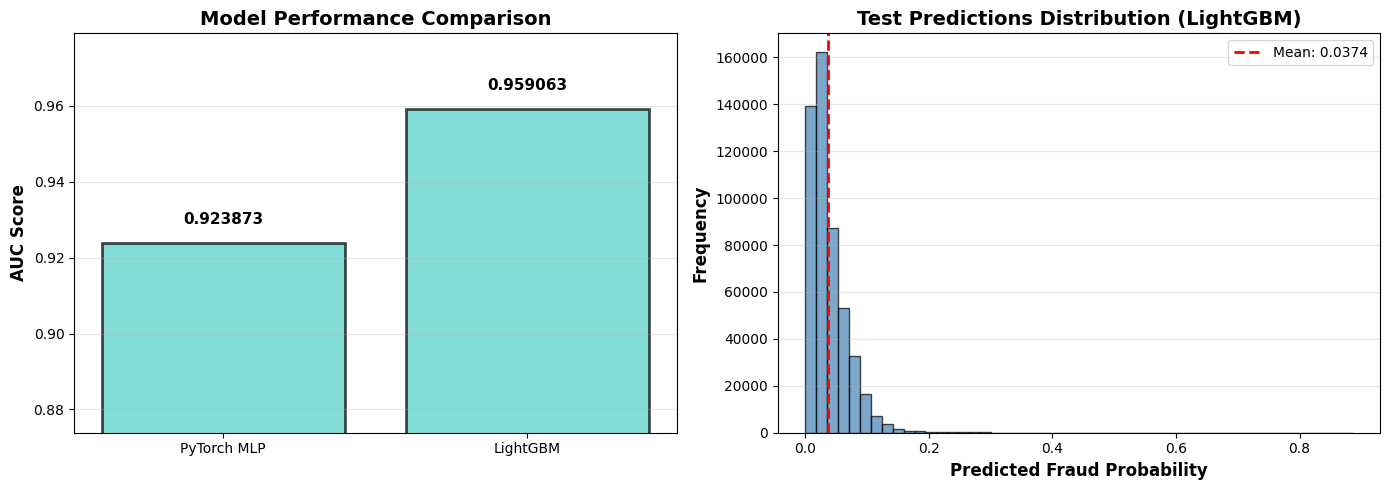


✓ Best Model: LightGBM with AUC = 0.959063


In [18]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# AUC Comparison
models = ['PyTorch MLP', 'LightGBM']
aucs = [nn_auc, lgb_auc]
colors = ['#FF6B6B' if nn_auc > lgb_auc else '#4ECDC4', 
          '#4ECDC4' if lgb_auc > nn_auc else '#FF6B6B']

axes[0].bar(models, aucs, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[0].set_ylabel('AUC Score', fontsize=12, fontweight='bold')
axes[0].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylim([min(aucs) - 0.05, max(aucs) + 0.02])
axes[0].grid(axis='y', alpha=0.3)

for i, (model, auc) in enumerate(zip(models, aucs)):
    axes[0].text(i, auc + 0.005, f'{auc:.6f}', ha='center', 
                 fontweight='bold', fontsize=11)

# Prediction Distribution
axes[1].hist(test_pred, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[1].set_xlabel('Predicted Fraud Probability', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1].set_title(f'Test Predictions Distribution ({best_model_name})', 
                  fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
axes[1].axvline(test_pred.mean(), color='red', linestyle='--', 
                linewidth=2, label=f'Mean: {test_pred.mean():.4f}')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\n✓ Best Model: {best_model_name} with AUC = {best_auc:.6f}")